# 3.8.1 Monotonic XGBoost Model
#### and comparison with non-monotonic model

## 1) Load Required Libraries

In [1]:
library("dplyr")
library("ggplot2")
library("ROSE")
library("xgboost")
library("gbm")
library("Matrix")
library("pdp") 
library("caret")
library("mltools")
library("data.table")
library("pROC")
library("PRROC")
library("rBayesianOptimization")
library("DiagrammeR")
library("MLmetrics")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loaded ROSE 0.0-3


Attaching package: ‘xgboost’

The following object is masked from ‘package:dplyr’:

    slice

Loaded gbm 2.1.5
Loading required package: lattice

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var


Attaching package: ‘PRROC’

The following object is masked from ‘package:ROSE’:

    roc.curve


Attaching package: ‘MLmetrics’

The following objects are masked from ‘package:caret’:

    MAE, RMSE

The following object is masked from ‘package:base’:

    Recall



## 2) Load Data

In [2]:
transformed2.df <- read.csv(file="TransfromedData2.csv", header=TRUE, sep=",")
glimpse(transformed2.df)

Observations: 884,570
Variables: 27
$ X                                      <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,…
$ loan_amnt                              <int> 5600, 7500, 12200, 11200, 2500…
$ term                                   <fct>  36 months,  36 months,  36 mo…
$ int_rate                               <dbl> 18.04, 13.87, 12.29, 11.34, 15…
$ installment                            <dbl> 202.57, 255.86, 406.91, 368.48…
$ grade                                  <fct> G, D, C, C, E, C, C, A, B, C, …
$ home_ownership                         <fct> OWN, MORTGAGE, OWN, RENT, MORT…
$ annual_inc                             <dbl> 0.6677529, 0.7174611, 0.661276…
$ verification_status                    <fct> Not Verified, Not Verified, No…
$ pymnt_plan                             <fct> n, n, n, n, n, n, n, n, n, n, …
$ purpose                                <fct> home_improvement, Others, home…
$ dti                                    <dbl> 25.84, 20.95, 9.31, 6.92, 6.82…
$ open_acc      

## 3) Transform Data for Modelling

### 3.1) Basic Transforms

Convert all factor levels to uppercase and replace spaces for underscores to make them more readable

In [3]:
transformed2.df <- transformed2.df %>% mutate(term = factor(term, labels = c('36MO', '60MO')),
        verification_status = factor(verification_status, labels = c('NOT_VERIFIED', 'SOURCE_VERIFIED', 'VERIFIED')),
        purpose = factor(purpose, labels = c('CREDIT_CARD', 'DEBT_CONSOLIDATION', 'HOME_IMPROVEMENT', 'MAJOR_PURCHASE', 'OTHERS', 'SMALL_BUSINESS')),
        initial_list_status = factor(initial_list_status, labels = c('F', 'W')),
        regions = factor(regions, labels = c('MIDWEST', 'NORTHEAST', 'SOUTH', 'WEST')),
        pymnt_plan = factor(pymnt_plan, labels = c("N", "Y")))

Rename external source columns for readability and ease of programmatic reference

In [4]:
transformed2.df <- transformed2.df %>% rename("compensation_of_employees" = "Compensation.of.employees", 
                           "gross_operating_surplus" = "Gross.operating.surplus",
                           "per_capita_real_gdp_by_state" = "Per.capita.real.GDP.by.state",
                           "quantity_indexes_for_real_gdp_by_state" = "Quantity.indexes.for.real.GDP.by.state",
                           "real_gdp_by_state" = "Real.GDP.by.state",
                           "subsidies" = "Subsidies",
                           "taxes_on_production_and_imports" = "Taxes.on.production.and.imports")

Add a `returns` with the amount expected to be gained from the loan from interests alone

In [5]:
transformed2.df <- transformed2.df %>% mutate(returns = (installment * ifelse(term=='36MO', 36, 60)) - loan_amnt)

Glimpse newly transformed dataframe

In [6]:
glimpse(transformed2.df)

Observations: 884,570
Variables: 28
$ X                                      <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,…
$ loan_amnt                              <int> 5600, 7500, 12200, 11200, 2500…
$ term                                   <fct> 36MO, 36MO, 36MO, 36MO, 36MO, …
$ int_rate                               <dbl> 18.04, 13.87, 12.29, 11.34, 15…
$ installment                            <dbl> 202.57, 255.86, 406.91, 368.48…
$ grade                                  <fct> G, D, C, C, E, C, C, A, B, C, …
$ home_ownership                         <fct> OWN, MORTGAGE, OWN, RENT, MORT…
$ annual_inc                             <dbl> 0.6677529, 0.7174611, 0.661276…
$ verification_status                    <fct> NOT_VERIFIED, NOT_VERIFIED, NO…
$ pymnt_plan                             <fct> N, N, N, N, N, N, N, N, N, N, …
$ purpose                                <fct> HOME_IMPROVEMENT, OTHERS, HOME…
$ dti                                    <dbl> 25.84, 20.95, 9.31, 6.92, 6.82…
$ open_acc      

### 3.2) One-hot encoded version (for monotonic constraints)

In [7]:
transformed2.1hot.df <- one_hot(as.data.table(transformed2.df))
glimpse(transformed2.1hot.df)

Observations: 884,570
Variables: 50
$ X                                      <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,…
$ loan_amnt                              <int> 5600, 7500, 12200, 11200, 2500…
$ term_36MO                              <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ term_60MO                              <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ int_rate                               <dbl> 18.04, 13.87, 12.29, 11.34, 15…
$ installment                            <dbl> 202.57, 255.86, 406.91, 368.48…
$ grade_A                                <int> 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, …
$ grade_B                                <int> 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, …
$ grade_C                                <int> 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, …
$ grade_D                                <int> 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, …
$ grade_E                                <int> 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, …
$ grade_F                                <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ grade_G       

### 3.3) Train / Test split both versions

Initialize Seed

In [8]:
seedNum = 19
set.seed(seedNum)

Create partitions

In [9]:
train.indx <- createDataPartition(y=transformed2.df$default, p=0.85, list=FALSE)
train.1hot.df <- transformed2.1hot.df[train.indx,-1]
test.1hot.df <- transformed2.1hot.df[-train.indx,-1]
train.df <- transformed2.df[train.indx,-1]
test.df <- transformed2.df[-train.indx,-1]

### 3.4) Create sampled versions of both training datasets (for cross validation)

Undersample train dataset for cross validation 

In [10]:
train.samp.indx <- createDataPartition(y=train.df$default, p=0.15, list=FALSE)
train.samp.df <- transformed2.1hot.df[train.samp.indx,-1]
train.samp.1hot.df <- transformed2.1hot.df[train.samp.indx,-1]

### 3.4) Calculate Sampled Medians (for Cost Sensitive Learning Evaluation )

Calculate mean sample returns

In [11]:
mreturns <- median(train.1hot.df$returns)
mreturns

[1] 2786.8

Median sample loan amount

In [12]:
mloan_amnt <- median(train.1hot.df$loan_amnt)
mloan_amnt

[1] 13000

### 3.6) Generate Y/X Sets for all versions

Remove returns from all training set to

In [13]:
y_train <- subset(train.1hot.df, select=default)
y_train.samp <- subset(train.samp.1hot.df, select=default)
x_train <- subset(train.df, select=-c(default, returns))
x_train.samp <- subset(train.samp.df, select=-c(default, returns))
y_test <- subset(test.1hot.df, select=default)
x_test <- subset(test.df, select=-c(default, returns))
x_train.1hot <- subset(train.1hot.df, select=-c(default, returns))
x_train.samp.1hot <- subset(train.samp.1hot.df, select=-c(default, returns))
x_test.1hot <- subset(test.1hot.df, select=-c(default, returns))

### 3.7) Create Constraint Matrix

**Calculate the Correlation Direction Between Response and Predictors**

In [14]:
mono <- cor(y_train, x_train.1hot, method = 'spearman', use="pairwise.complete.obs") / abs(cor(y_train, x_train.1hot, method = 'spearman', use="pairwise.complete.obs"))

Take a look at the constraints

In [15]:
glimpse(as.data.frame(mono))

Observations: 1
Variables: 47
$ loan_amnt                              <dbl> -1
$ term_36MO                              <dbl> -1
$ term_60MO                              <dbl> 1
$ int_rate                               <dbl> 1
$ installment                            <dbl> 1
$ grade_A                                <dbl> -1
$ grade_B                                <dbl> -1
$ grade_C                                <dbl> 1
$ grade_D                                <dbl> 1
$ grade_E                                <dbl> 1
$ grade_F                                <dbl> 1
$ grade_G                                <dbl> 1
$ home_ownership_MORTGAGE                <dbl> -1
$ home_ownership_OWN                     <dbl> -1
$ home_ownership_RENT                    <dbl> 1
$ annual_inc                             <dbl> -1
$ verification_status_NOT_VERIFIED       <dbl> -1
$ verification_status_SOURCE_VERIFIED    <dbl> -1
$ verification_status_VERIFIED           <dbl> 1
$ pymnt_plan_N                

### 3.8) Create DMatrixes

In [19]:
dtrain.1hot <- xgb.DMatrix(data = data.matrix(x_train.1hot), label = data.matrix(y_train))
dtrain.samp.1hot <- xgb.DMatrix(data = data.matrix(x_train.samp.1hot), label = data.matrix(y_train.samp))
dtrain.samp <- xgb.DMatrix(data = data.matrix(x_train.samp), label = data.matrix(y_train.samp))
dtrain <- xgb.DMatrix(data = data.matrix(x_train), label = data.matrix(y_train))

### 3.9) Create Folds on Sampling

In [16]:
cv_folds <- KFold(y_train.samp$default, nfolds = 5, stratified = FALSE, seed=seedNum)

## 4) Modelling

### 4.1) Monotonic Constrained XGBoost

#### 4.1.1) Perform Hyperparameter Tuning with Bayesian Optimization and Cross Validation on the Training Data Sample

Optimize the PR AUC

In [29]:
xgb.mono.cv.bayes <- function(nround, max_depth, min_child_weight, eta, gamma) { # subsample, colsample_bytree, max_delta_step
    xgb.getLift <- function(preds, dtrain) {
        labels <- getinfo(dtrain, "label")
        lift <- getLift(preds, labels, thresholds[i])
        return(list(metric = "Lift", value = lift))
    }
    params <- list(
                    booster = "gbtree", #"gblinear", "dart"
                    max_depth = max_depth,
                    min_child_weight = min_child_weight,
                    eta = eta,
                    gamma = gamma,
                    subsample = 0.9, #subsample, 
                    colsample_bytree = 0.8, #colsample_bytree,
                    #max_delta_step = max_delta_step,
                    #lambda = 1, 
                    #alpha = 0,
                    objective = "binary:logistic",
                    eval_metric = "aucpr", 
                    monotone_constraints = mono
                 )
    cv <- xgb.cv(params = params, data = dtrain.samp.1hot, folds = cv_folds, nrounds = 300, 
                 early_stopping_rounds = 20, maximize = TRUE, verbose = TRUE, print_every_n=20)
    return(list(Score = cv$evaluation_log$test_aucpr_mean[cv$best_iteration], Pred=cv$best_iteration))
}

In [30]:
stime <- Sys.time()
xgb.mono.cv.bayes.opt <- BayesianOptimization(xgb.mono.cv.bayes,
                              bounds = list(max_depth = c(3L, 15L), 
                                            min_child_weight = c(1L, 7L),
                                            eta=c(0.05, 0.3),
                                            gamma = c(0.0, 0.4) #,
                                            #subsample = c(0.6, 0.9),
                                            #colsample_bytree=c(0.3, 0.7),
                                            #max_delta_step=c(1L, 10L)
                                        ),
                              init_grid_dt = NULL, init_points = 10, n_iter = 10,
                              acq = "ucb", kappa = 2.576, eps = 0.0, verbose = FALSE)
print(Sys.time() - stime)


 Best Parameters Found: 
Round = 14	max_depth = 9.0000	min_child_weight = 3.0000	eta = 0.1235	gamma = 0.0600	Value = 0.1696 
Time difference of 25.23762 mins


**Bayesian Optimization History**

In [31]:
xgb.mono.cv.bayes.opt$History

Round,max_depth,min_child_weight,eta,gamma,Value
1,8,4,0.07271464,0.265945908,0.1687354
2,7,4,0.07589280,0.046489001,0.1691880
3,9,3,0.05422341,0.102699775,0.1691848
4,11,6,0.05380360,0.162892138,0.1682702
5,10,5,0.07208863,0.034798493,0.1681436
6,5,6,0.13791058,0.314659841,0.1686334
7,13,4,0.29243773,0.094681766,0.1682176
8,13,5,0.18768913,0.346128870,0.1674650
9,12,2,0.10547161,0.160181972,0.1687480
10,13,6,0.29918105,0.008326368,0.1682072


**Bayesian Optimization Best Parameters**

In [32]:
xgb.mono.cv.bayes.opt$Best_Par

max_depth min_child_weight              eta            gamma 
      9.00000000       3.00000000       0.12353491       0.06003532

**Set Optimal # Rounds**

In [33]:
xgb.mono.cv.bayes.opt.nrounds <- xgb.mono.cv.bayes.opt$Pred[[which.max(xgb.mono.cv.bayes.opt$History$Value)]]
xgb.mono.cv.bayes.opt.nrounds

[1] 176

#### 4.1.2) Perform Cost Sensitive Learning with Cross Validation on the Training Data Sample

**Objective Functions to Test**

In [46]:
#To Minimize
getCost <- function(obs, pred, threshold = 0.5) {
    tp_num <- sum(obs == 1 & obs == pred) #No Value assigned
    tn_num <- sum(obs == 0 & obs == pred) #No Value assigned
    fp_num <- sum(obs == 0 & obs != pred) #Value of median loan_amnt 
    fn_num <- sum(obs == 1 & obs != pred) #Value of median returns
    profit <- (tn_num * mreturns) + (fn_num * mloan_amnt)
    return(profit)
}

#To Maximize
getProfit <- function(obs, pred, threshold = 0.5) {
    pred <- ifelse(pred >= threshold, 1, 0)
    tp_num <- sum(obs == 1 & obs == pred) #No Value assigned
    tn_num <- sum(obs == 0 & obs == pred) #Value of median returns
    fp_num <- sum(obs == 0 & obs != pred) #No Value assigned
    fn_num <- sum(obs == 1 & obs != pred) #Value of median loan_amnt
    #print(sprintf("%s, %s, %s, %s", tp_num, tn_num, fp_num, fn_num))
    profit <- (tn_num * mreturns) - (fn_num * mloan_amnt)
    return(profit)
}

# Predict non-returning for everyone
getBenchmarkProfit <- function(obs) { 
  n <- length(obs)
  getProfit(obs, rep(0, times = n))
}

getLift <- function(probs, labels, thresh) {
    pred_profit <- as.numeric(getProfit(obs = labels,
                                      pred = probs,
                                      threshold = thresh))
    naive_profit <- as.numeric(getBenchmarkProfit(labels))
    profit_lift <- pred_profit/naive_profit
    #print(sprintf("%.2f / %.2f = %.4f", pred_profit, naive_profit, profit_lift))
    return(profit_lift)
}

**Custom Cost Sensitive Learning Function**

In [49]:
CSL <- function(params, data, nfold, nrounds, tstart, tend, tinterval, feval = "lift", verbose = FALSE, print_every_n = 50){
    thresholds <- seq(tstart, tend, by = tinterval)
    performance <- vector(length = length(thresholds))
    for(i in 1:length(thresholds)) {
        print(paste(i, ":", thresholds[i]))
        xgb.getCost <- function(preds, dtrain) {
            labels <- getinfo(dtrain, "label")
            cost <- getCost(labels, preds, thresholds[i])
            return(list(metric = "Cost", value = cost))
        }
        xgb.getLift <- function(preds, dtrain) {
            labels <- getinfo(dtrain, "label")
            lift <- getLift(preds, labels, thresholds[i])
            return(list(metric = "Lift", value = lift))
        }
        # train the model again using the current threshold 
        if (feval == "lift"){
            xgb.csl <- xgb.cv(params = params, data = data, nfold = nfold,
                            nrounds = nrounds, feval = xgb.getLift, maximize = TRUE, 
                            early_stopping_rounds = 10, verbose = verbose, print_every_n = print_every_n)   
        }else{
            xgb.csl <- xgb.cv(params = params, data = data, nfold = nfold,
                            nrounds = nrounds, feval = xgb.getCost, maximize = FALSE, 
                            early_stopping_rounds = 10, verbose = verbose, print_every_n = print_every_n)  
        }
        # store results
        performance[i] <- as.data.frame(xgb.csl$evaluation_log)[xgb.csl$best_iteration,4]
    }
    return(list("thresholds" = thresholds, "performance" = performance))
}

**Run CSL on a 0.003 threshold interval**

In [50]:
params <- list(
                objective = "binary:logistic",
                eta = xgb.mono.cv.bayes.opt$Best_Par["eta"],
                max_depth = xgb.mono.cv.bayes.opt$Best_Par["max_depth"],
                gamma = xgb.mono.cv.bayes.opt$Best_Par["gamma"],
                min_child_weight = xgb.mono.cv.bayes.opt$Best_Par["min_child_weight"],
                subsample = 0.75,
                colsample_bytree = 1,
                monotone_constraints = mono
              )
stime <- Sys.time()
xgb.mono.CSL.cv.opt1 <- CSL(params, dtrain.samp.1hot, 5, xgb.mono.cv.bayes.opt.nrounds, 
                           0.1, 0.69, 0.03, feval = "lift")
print(Sys.time() - stime)

[1] "1 : 0.1"
[1] "2 : 0.13"
[1] "3 : 0.16"
[1] "4 : 0.19"
[1] "5 : 0.22"
[1] "6 : 0.25"
[1] "7 : 0.28"
[1] "8 : 0.31"
[1] "9 : 0.34"
[1] "10 : 0.37"
[1] "11 : 0.4"
[1] "12 : 0.43"
[1] "13 : 0.46"
[1] "14 : 0.49"
[1] "15 : 0.52"
[1] "16 : 0.55"
[1] "17 : 0.58"
[1] "18 : 0.61"
[1] "19 : 0.64"
[1] "20 : 0.67"
Time difference of 3.504518 mins


**Plot the lift for every threshold in the 0.10-0.69 range**

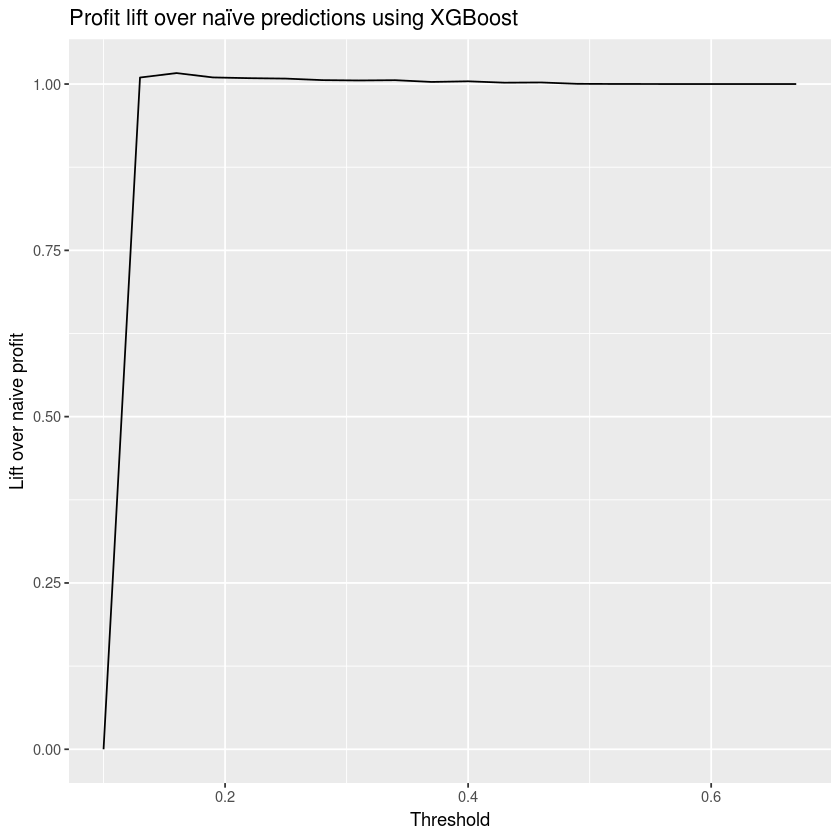

In [60]:
xgb.mono.CSL.cv.opt1.df <- as.data.frame(xgb.mono.CSL.cv.opt1)
ggplot(xgb.mono.CSL.cv.opt1.df, aes(x = thresholds, y = performance)) +
  geom_line() +
  labs(title = "Profit lift over naïve predictions using XGBoost",
          x = "Threshold", y = "Lift over naive profit")

**Set Optimal Threshold for CSL on a 0.03 scale**

In [58]:
xgb.mono.CSL.cv.opt1.threshold <- xgb.mono.CSL.cv.opt1.df$thresholds[which.max(xgb.mono.CSL.cv1.opt.df$performance)]
xgb.mono.CSL.cv.opt1.threshold

[1] 0.16

**Get more granular at a 0.005 threshold level**

In [63]:
params <- list(
                objective = "binary:logistic",
                eta = xgb.mono.cv.bayes.opt$Best_Par["eta"],
                max_depth = xgb.mono.cv.bayes.opt$Best_Par["max_depth"],
                gamma = xgb.mono.cv.bayes.opt$Best_Par["gamma"],
                min_child_weight = xgb.mono.cv.bayes.opt$Best_Par["min_child_weight"],
                subsample = 0.75,
                colsample_bytree = 1,
                monotone_constraints = mono
              )
stime <- Sys.time()
xgb.mono.CSL.cv.opt2 <- CSL(params, dtrain.samp.1hot, 5, xgb.mono.cv.bayes.opt.nrounds, 
                           xgb.mono.CSL.cv.opt1.threshold - 0.03, xgb.mono.CSL.cv.opt1.threshold + 0.03, 0.005, feval = "lift")
print(Sys.time() - stime)

[1] "1 : 0.13"
[1] "2 : 0.135"
[1] "3 : 0.14"
[1] "4 : 0.145"
[1] "5 : 0.15"
[1] "6 : 0.155"
[1] "7 : 0.16"
[1] "8 : 0.165"
[1] "9 : 0.17"
[1] "10 : 0.175"
[1] "11 : 0.18"
[1] "12 : 0.185"
[1] "13 : 0.19"
Time difference of 8.78262 mins


**Plot the lift for every threshold in the 0.13-0.19 range**

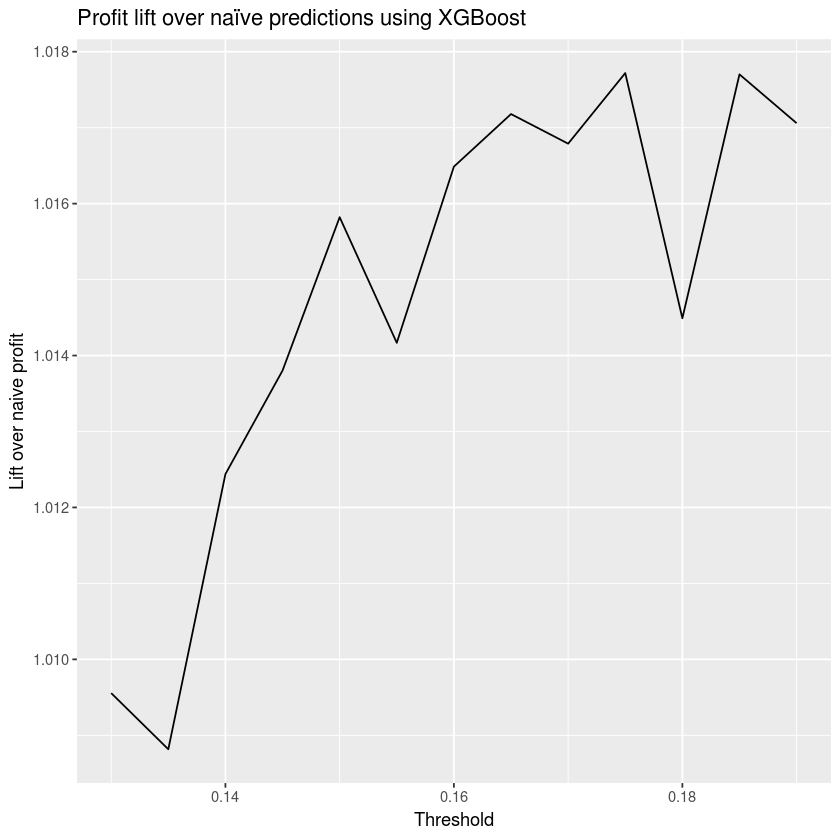

In [64]:
xgb.mono.CSL.cv.opt2.df <- as.data.frame(xgb.mono.CSL.cv.opt2)
ggplot(xgb.mono.CSL.cv.opt2.df, aes(x = thresholds, y = performance)) +
  geom_line() +
  labs(title = "Profit lift over naïve predictions using XGBoost",
          x = "Threshold", y = "Lift over naive profit")

**Set Optimal Threshold for CSL on a 0.005 scale**

In [66]:
xgb.mono.CSL.cv.opt2.threshold <- xgb.mono.CSL.cv.opt2.df$thresholds[which.max(xgb.mono.CSL.cv.opt2.df$performance)]
xgb.mono.CSL.cv.opt2.threshold

[1] 0.175

#### 4.1.3) Run & Test XGBoost on Optimal Params but on Full Training Set

**Set Optimal Params for Monotonic**

In [34]:
xgb.mono.cv.bayes.opt.params <- list(
    booster = "gbtree",
    max_depth = xgb.mono.cv.bayes.opt$Best_Par["max_depth"],
    min_child_weight = xgb.mono.cv.bayes.opt$Best_Par["min_child_weight"],
    eta = xgb.mono.cv.bayes.opt$Best_Par["eta"],
    gamma = xgb.mono.cv.bayes.opt$Best_Par["gamma"],
    subsample = 0.9, #xgb.mono.cv.bayes.opt$Best_Par["subsample"],
    colsample_bytree = 0.8, #xgb.mono.cv.bayes.opt$Best_Par["colsample_bytree"],
    #max_delta_step = xgb.mono.cv.bayes.opt$Best_Par["max_delta_step"], 
    objective = "binary:logistic",
    eval_metric=c("logloss", "auc", "aucpr", "error"),
    monotone_constraints = mono
)

**Train model on full training set**

In [67]:
stime <- Sys.time()
xgb.mono.opt.mdl <- xgb.train (params = xgb.mono.cv.bayes.opt.params, nrounds = xgb.mono.cv.bayes.opt.nrounds, data = dtrain.1hot, 
                              verbose=1, print_every_n=5)
print(Sys.time() - stime)

Time difference of 2.22174 mins


**Get Predictions using Test Dataset**

In [68]:
xgb.mono.opt.pred <- predict(xgb.mono.opt.mdl, as.matrix(x_test.1hot))

**Plot ROC Curve**

In [70]:
xgb.mono.opt.pred.fg <- xgb.mono.opt.pred[y_test$default==TRUE]
xgb.mono.opt.pred.bg <- xgb.mono.opt.pred[y_test$default==FALSE]

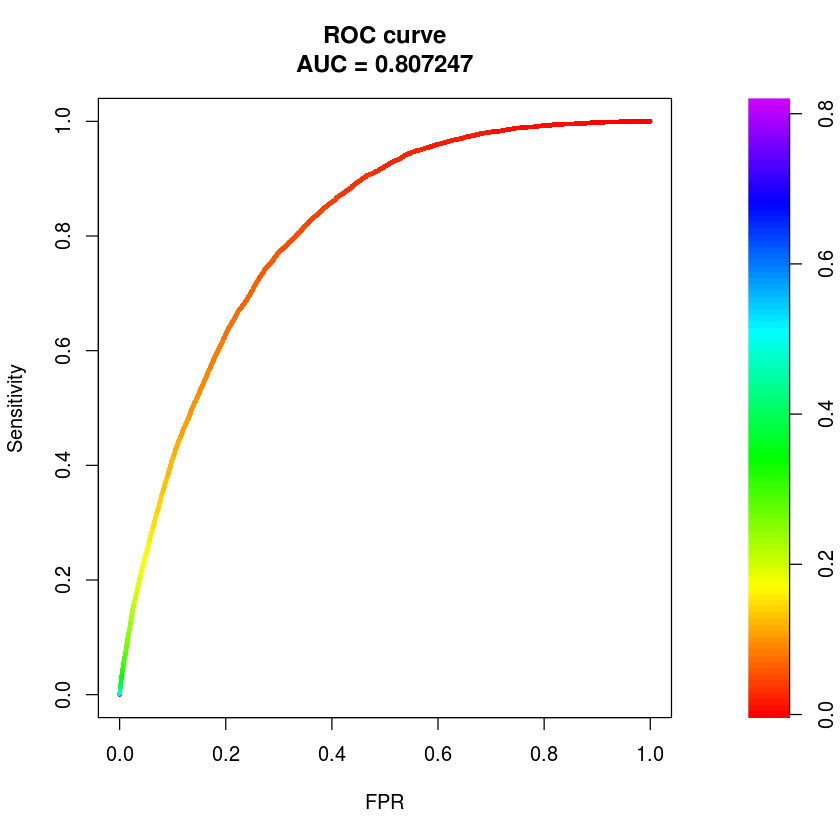

In [71]:
xgb.mono.opt.roc <- roc.curve(scores.class0 = xgb.mono.opt.pred.fg, scores.class1 = xgb.mono.opt.pred.bg, curve = T)
plot(xgb.mono.opt.roc)

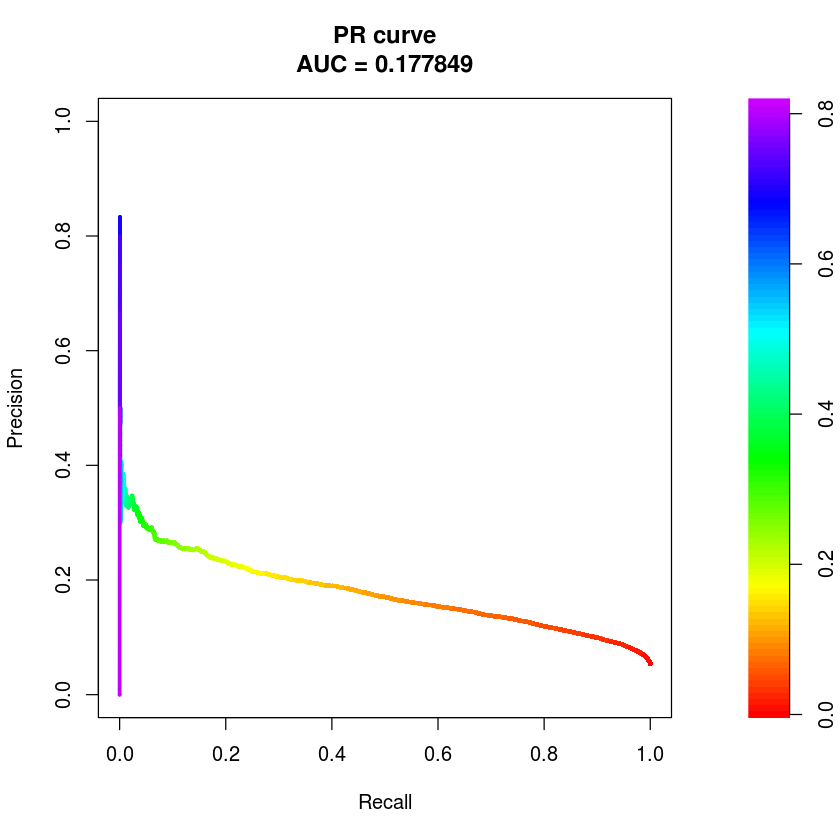

In [72]:
xgb.mono.opt.prc <- pr.curve(scores.class0 = xgb.mono.opt.pred.fg, scores.class1 = xgb.mono.opt.pred.bg, curve = T)
plot(xgb.mono.opt.prc)

**Calculate AUC**

In [74]:
xgb.mono.opt.auc <- auc(roc(y_test$default, xgb.mono.opt.pred))
xgb.mono.opt.auc

Area under the curve: 0.8072

**Calculate F-score**

In [75]:
xgb.mono.opt.f1 <- F1_Score(ifelse(xgb.mono.opt.pred > xgb.mono.CSL.cv.opt2.threshold, 1, 0), ifelse(y_test$default, 1, 0), positive = "0")
xgb.mono.opt.f1

[1] 0.9551175

**Generate and Save Confusion Matrix**

In [73]:
xgb.mono.opt.cm <- confusionMatrix(table(xgb.mono.opt.pred > xgb.mono.CSL.cv.opt2.threshold, y_test$default))
xgb.mono.opt.cm

Confusion Matrix and Statistics

       
         FALSE   TRUE
  FALSE 119766   5400
  TRUE    5856   1663
                                          
               Accuracy : 0.9152          
                 95% CI : (0.9137, 0.9167)
    No Information Rate : 0.9468          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1833          
                                          
 Mcnemar's Test P-Value : 1.798e-05       
                                          
            Sensitivity : 0.9534          
            Specificity : 0.2355          
         Pos Pred Value : 0.9569          
         Neg Pred Value : 0.2212          
             Prevalence : 0.9468          
         Detection Rate : 0.9026          
   Detection Prevalence : 0.9433          
      Balanced Accuracy : 0.5944          
                                          
       'Positive' Class : FALSE           
                                 

**Calculate Feature Importance/Influence**

In [76]:
xgb.mono.opt.imp <- xgb.importance(model = xgb.mono.opt.mdl)
print(xgb.mono.opt.imp)

                                   Feature         Gain        Cover
 1:                               int_rate 0.2844785140 0.1289872057
 2: quantity_indexes_for_real_gdp_by_state 0.1982133119 0.1065392095
 3:                      real_gdp_by_state 0.0716099972 0.0784651982
 4:                  initial_list_status_F 0.0631546241 0.0273675034
 5:                              subsidies 0.0542717509 0.0740487226
 6:              compensation_of_employees 0.0415941106 0.0441476333
 7:                             annual_inc 0.0411808065 0.0568885978
 8:        taxes_on_production_and_imports 0.0375805764 0.0536641750
 9:                                  month 0.0340116021 0.0430751861
10:                gross_operating_surplus 0.0328176240 0.0519784075
11:           per_capita_real_gdp_by_state 0.0299016295 0.0402028044
12:                  initial_list_status_W 0.0237556841 0.0073579205
13:                            installment 0.0138090561 0.0696311595
14:                              l

**Plot Importance/Influence**

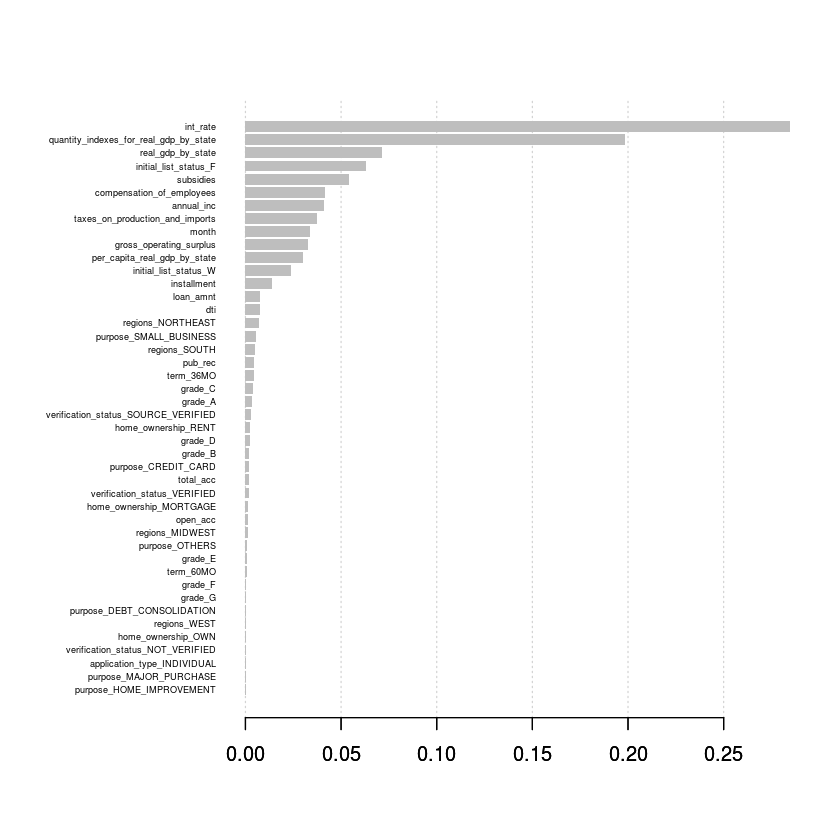

In [77]:
xgb.plot.importance(importance_matrix = xgb.mono.opt.imp)

**Dump Tree**

In [78]:
xgb.dump(xgb.mono.opt.mdl, with.stats = T, fname = "./models/xgb.mono.opt.tree.costopt.txt")

Warning message:
“'with.stats' is deprecated.
Use 'with_stats' instead.
See help("Deprecated") and help("xgboost-deprecated").”

[1] TRUE

**Save Model**

In [79]:
xgb.save(xgb.mono.opt.mdl, "./models/xgb.mono.opt.costopt.mdl")

[1] TRUE

**Partial Graph (for 3 top vars)**

In [115]:
stime <- Sys.time()
xgb.mono.opt.mdl.1p <- partial(xgb.mono.opt.mdl, pred.var = "int_rate", train = x_train.1hot,
                                 grid.resolution = 250, trim.outliers = FALSE, prob = TRUE, rug = TRUE, plot = TRUE)
print(Sys.time() - stime)

In [ ]:
stime <- Sys.time()
xgb.mono.opt.mdl.2p <- partial(xgb.mono.opt.mdl, pred.var = "quantity_indexes_for_real_gdp_by_state", train = x_train.1hot,
                                 grid.resolution = 250, trim.outliers = FALSE, prob = TRUE, rug = TRUE, plot = TRUE)
print(Sys.time() - stime)

In [ ]:
stime <- Sys.time()
xgb.mono.opt.mdl.3p <- partial(xgb.mono.opt.mdl, pred.var = "annual_inc", train = x_train.1hot,
                                 grid.resolution = 250, trim.outliers = FALSE, prob = TRUE, rug = TRUE, plot = TRUE)
print(Sys.time() - stime)

#### 4.1.4) Calculate Model Relative Losses

**Losses ($L$)**: We cannot calculate the Loss Given Default (LGD) or Exposure to Default (EAD) precisely because we don't know what is the value of the collateral for each loan and administrative costs associated to a default so we are going to assume it's `loan_amnt` which is potentially a larger amount.

**Returns ($R$)**: We cannot calculate the Return on Allocated Equity (ROE) precisely because to do this we would need to factor cost of funds, income taxes and other costs associated in producing this money but we can calculate how much money is _yielded by the interest of each loan_ should it go to full term. Although this can be calculated using the compounded annualized `int_rate` on the `loan_amnt` for the duration of the `term` and deduct the `loan_amnt`. It's far easier to just leverage the `installment` column like this:

(`installment` * `term`) - `loan_amnt`

So I devised a way to best depict the relative amount of losses like this:

Cost Ratio = $\large{\frac{R(FN) + L(FP)}{R(TN)}}$ 

Which is the ratio produced by bad predictions over the total amount made by good predictions. In other words the total lost loan principals by false negatives plus the total lost in revenue by false positives over the total produced in revenue by true negatives.

In [126]:
xgb.mono.opt.cost.ratio <- ((xgb.mono.opt.cm$table[2,1]*mreturns)+(xgb.mono.opt.cm$table[1,2]*mloan_amnt)) / ((xgb.mono.opt.cm$table[1,1]*mreturns))
xgb.mono.opt.cost.ratio

[1] 0.2592237

### 4.2) Non-Monotonic Constrained XGBoost

#### 4.2.1) Perform Hyperparameter Tuning with Bayesian Optimization and Cross Validation on the Training Data Sample

Optimize the PR AUC

In [80]:
xgb.cv.bayes <- function(nround, max_depth, min_child_weight, eta, gamma) { # subsample, colsample_bytree, max_delta_step
    params <- list(
                    booster = "gbtree", #"gblinear", "dart"
                    max_depth = max_depth,
                    min_child_weight = min_child_weight,
                    eta = eta,
                    gamma = gamma,
                    subsample = 0.9, #subsample, 
                    colsample_bytree = 0.8, #colsample_bytree,
                    #max_delta_step = max_delta_step,
                    #lambda = 1, 
                    #alpha = 0,
                    objective = "binary:logistic",
                    eval_metric = "aucpr"
                 )
    cv <- xgb.cv(params = params, data = dtrain.samp.1hot, folds = cv_folds, nrounds = 500, 
                 early_stopping_rounds = 10, maximize = TRUE, verbose = TRUE, print_every_n=20)
    return(list(Score = cv$evaluation_log$test_aucpr_mean[cv$best_iteration], Pred=cv$best_iteration))
}

In [81]:
stime <- Sys.time()
xgb.cv.bayes.opt <- BayesianOptimization(xgb.cv.bayes,
                              bounds = list(max_depth = c(3L, 15L), 
                                            min_child_weight = c(1L, 7L),
                                            eta=c(0.05, 0.3),
                                            gamma = c(0.0, 0.4) #,
                                            #subsample = c(0.6, 0.9),
                                            #colsample_bytree=c(0.3, 0.7),
                                            #max_delta_step=c(1L, 10L)
                                        ),
                              init_grid_dt = NULL, init_points = 10, n_iter = 10,
                              acq = "ucb", kappa = 2.576, eps = 0.0, verbose = FALSE)
print(Sys.time() - stime)


 Best Parameters Found: 
Round = 12	max_depth = 3.0000	min_child_weight = 5.0000	eta = 0.1127	gamma = 0.0704	Value = 0.1842 
Time difference of 12.16042 mins


**Bayesian Optimization History**

In [82]:
xgb.cv.bayes.opt$History

Round,max_depth,min_child_weight,eta,gamma,Value
1,10,2,0.06100444,2.480890e-01,0.1713648
2,7,4,0.25770141,3.290715e-01,0.1667714
3,4,6,0.07933967,3.070848e-01,0.1812742
4,13,3,0.06082554,1.147279e-01,0.1673892
5,12,6,0.15109382,2.791822e-01,0.1643116
6,4,4,0.19858879,3.008555e-01,0.1786960
7,5,7,0.22571012,2.931242e-01,0.1755438
8,8,4,0.19229396,3.204153e-01,0.1750228
9,12,3,0.13688850,1.167994e-01,0.1644986
10,14,4,0.05259967,4.490848e-02,0.1669682


**Bayesian Optimization Best Parameters**

In [83]:
xgb.cv.bayes.opt$Best_Par

max_depth min_child_weight              eta            gamma 
      3.00000000       5.00000000       0.11268020       0.07042609

**Set Optimal # Rounds**

In [87]:
xgb.cv.bayes.opt.nrounds <- xgb.cv.bayes.opt$Pred[[which.max(xgb.cv.bayes.opt$History$Value)]]
xgb.cv.bayes.opt.nrounds

[1] 301

#### 4.1.2) Perform Cost Sensitive Learning with Cross Validation on the Training Data Sample

**Run CSL on a 0.003 threshold interval**

In [88]:
params <- list(
                objective = "binary:logistic",
                eta = xgb.cv.bayes.opt$Best_Par["eta"],
                max_depth = xgb.cv.bayes.opt$Best_Par["max_depth"],
                gamma = xgb.cv.bayes.opt$Best_Par["gamma"],
                min_child_weight = xgb.cv.bayes.opt$Best_Par["min_child_weight"],
                subsample = 0.75,
                colsample_bytree = 1
              )
stime <- Sys.time()
xgb.CSL.cv.opt1 <- CSL(params, dtrain.samp.1hot, 5, xgb.cv.bayes.opt.nrounds, 
                           0.1, 0.69, 0.03, feval = "lift")
print(Sys.time() - stime)

[1] "1 : 0.1"
[1] "2 : 0.13"
[1] "3 : 0.16"
[1] "4 : 0.19"
[1] "5 : 0.22"
[1] "6 : 0.25"
[1] "7 : 0.28"
[1] "8 : 0.31"
[1] "9 : 0.34"
[1] "10 : 0.37"
[1] "11 : 0.4"
[1] "12 : 0.43"
[1] "13 : 0.46"
[1] "14 : 0.49"
[1] "15 : 0.52"
[1] "16 : 0.55"
[1] "17 : 0.58"
[1] "18 : 0.61"
[1] "19 : 0.64"
[1] "20 : 0.67"
Time difference of 1.405682 mins


**Plot the lift for every threshold in the 0.10-0.69 range**

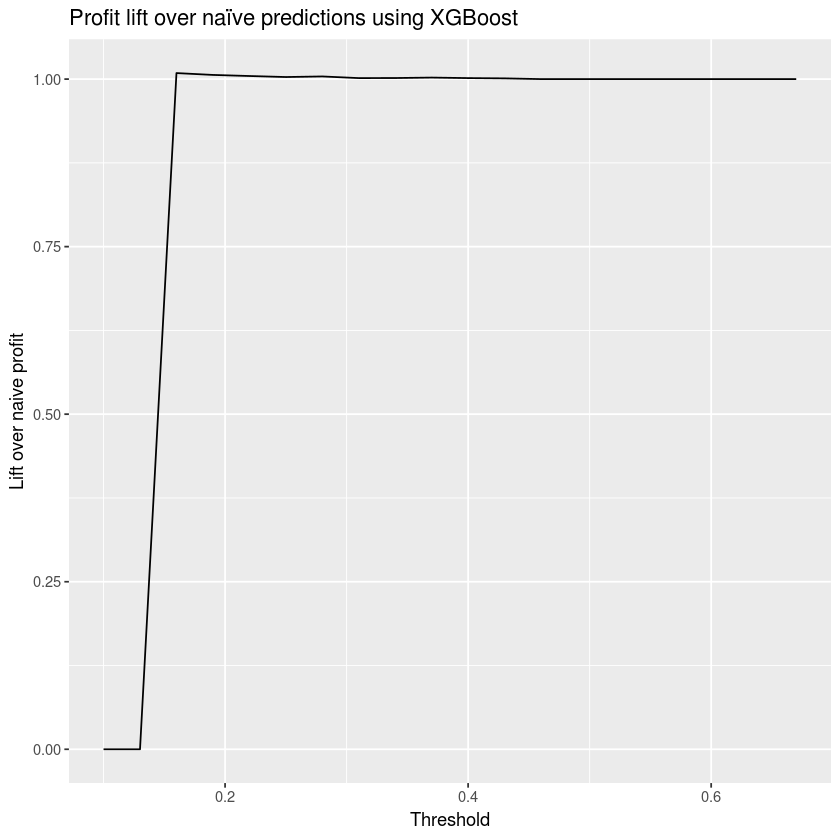

In [89]:
xgb.CSL.cv.opt1.df <- as.data.frame(xgb.CSL.cv.opt1)
ggplot(xgb.CSL.cv.opt1.df, aes(x = thresholds, y = performance)) +
  geom_line() +
  labs(title = "Profit lift over naïve predictions using XGBoost",
          x = "Threshold", y = "Lift over naive profit")

**Set Optimal Threshold for CSL on a 0.03 scale**

In [91]:
xgb.CSL.cv.opt1.threshold <- xgb.CSL.cv.opt1.df$thresholds[which.max(xgb.CSL.cv.opt1.df$performance)]
xgb.CSL.cv.opt1.threshold

[1] 0.16

**Get more granular at a 0.005 threshold level**

In [92]:
params <- list(
                objective = "binary:logistic",
                eta = xgb.cv.bayes.opt$Best_Par["eta"],
                max_depth = xgb.cv.bayes.opt$Best_Par["max_depth"],
                gamma = xgb.cv.bayes.opt$Best_Par["gamma"],
                min_child_weight = xgb.cv.bayes.opt$Best_Par["min_child_weight"],
                subsample = 0.75,
                colsample_bytree = 1,
                monotone_constraints = mono
              )
stime <- Sys.time()
xgb.CSL.cv.opt2 <- CSL(params, dtrain.samp.1hot, 5, xgb.cv.bayes.opt.nrounds, 
                           xgb.CSL.cv.opt1.threshold - 0.03, xgb.CSL.cv.opt1.threshold + 0.03, 0.005, feval = "lift")
print(Sys.time() - stime)

[1] "1 : 0.13"
[1] "2 : 0.135"
[1] "3 : 0.14"
[1] "4 : 0.145"
[1] "5 : 0.15"
[1] "6 : 0.155"
[1] "7 : 0.16"
[1] "8 : 0.165"
[1] "9 : 0.17"
[1] "10 : 0.175"
[1] "11 : 0.18"
[1] "12 : 0.185"
[1] "13 : 0.19"
Time difference of 2.393708 mins


**Plot the lift for every threshold in the 0.13-0.19 range**

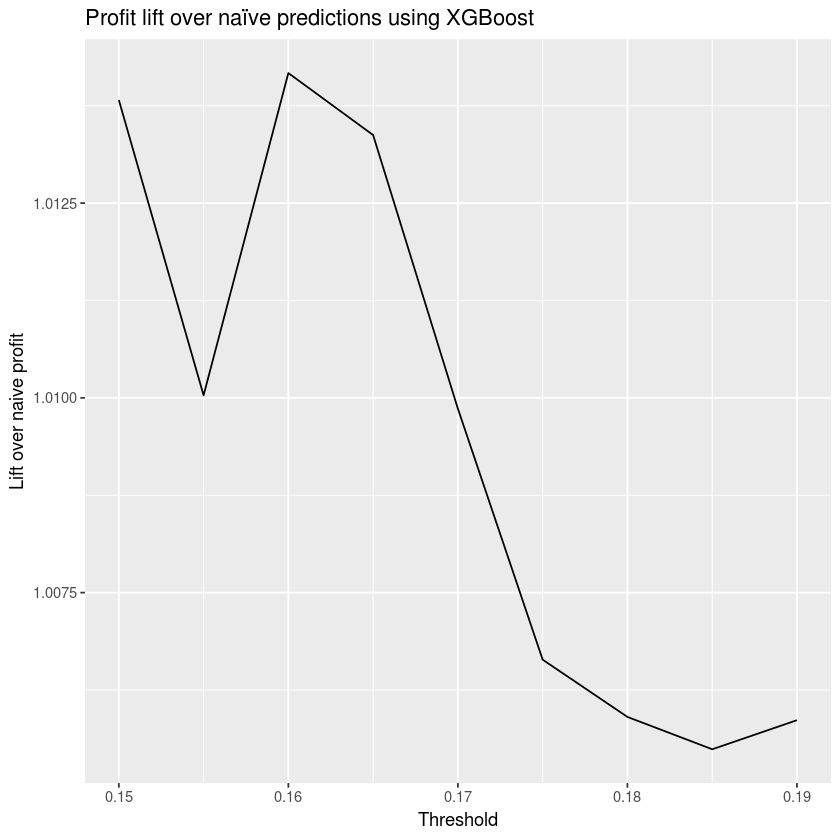

In [98]:
xgb.CSL.cv.opt2.df <- as.data.frame(xgb.CSL.cv.opt2)
ggplot(xgb.CSL.cv.opt2.df[which(xgb.CSL.cv.opt2.df$performance>0),], aes(x = thresholds, y = performance)) +
  geom_line() +
  labs(title = "Profit lift over naïve predictions using XGBoost",
          x = "Threshold", y = "Lift over naive profit")

**Set Optimal Threshold for CSL on a 0.005 scale**

In [99]:
xgb.CSL.cv.opt2.threshold <- xgb.CSL.cv.opt2.df$thresholds[which.max(xgb.CSL.cv.opt2.df$performance)]
xgb.CSL.cv.opt2.threshold

[1] 0.16

#### 4.2.2) Run & Test XGBoost on Optimal Params but on Full Training Set

**Set Optimal Params for Non-Monotonic**

In [85]:
xgb.cv.bayes.opt.params <- list(
    booster = "gbtree",
    max_depth = xgb.cv.bayes.opt$Best_Par["max_depth"],
    min_child_weight = xgb.cv.bayes.opt$Best_Par["min_child_weight"],
    eta = xgb.cv.bayes.opt$Best_Par["eta"],
    gamma = xgb.cv.bayes.opt$Best_Par["gamma"],
    subsample = 0.9, #xgb.cv.bayes.opt$Best_Par["subsample"],
    colsample_bytree = 0.8, #xgb.cv.bayes.opt$Best_Par["colsample_bytree"],
    #max_delta_step = xgb.cv.bayes.opt$Best_Par["max_delta_step"], 
    objective = "binary:logistic",
    eval_metric=c("logloss", "auc", "aucpr", "error")
)

**Train model on full training set**

In [101]:
stime <- Sys.time()
xgb.opt.mdl <- xgb.train(params = xgb.cv.bayes.opt.params, nrounds = xgb.cv.bayes.opt.nrounds, data = dtrain.1hot, 
                              verbose=1, print_every_n=30)
print(Sys.time() - stime)

Time difference of 1.229811 mins


**Get Predictions using Test Dataset**

In [102]:
xgb.opt.pred <- predict(xgb.opt.mdl, as.matrix(x_test.1hot))

**Plot ROC Curve**

In [105]:
xgb.opt.pred.fg <- xgb.opt.pred[y_test$default==TRUE]
xgb.opt.pred.bg <- xgb.opt.pred[y_test$default==FALSE]

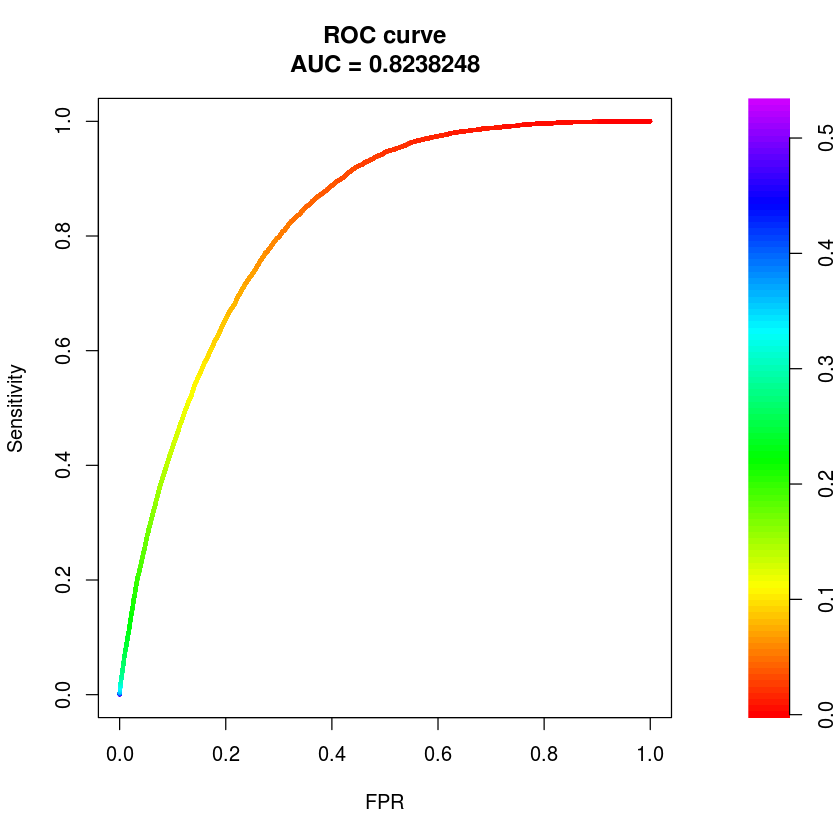

In [106]:
xgb.opt.roc <- roc.curve(scores.class0 = xgb.opt.pred.fg, scores.class1 = xgb.opt.pred.bg, curve = T)
plot(xgb.opt.roc)

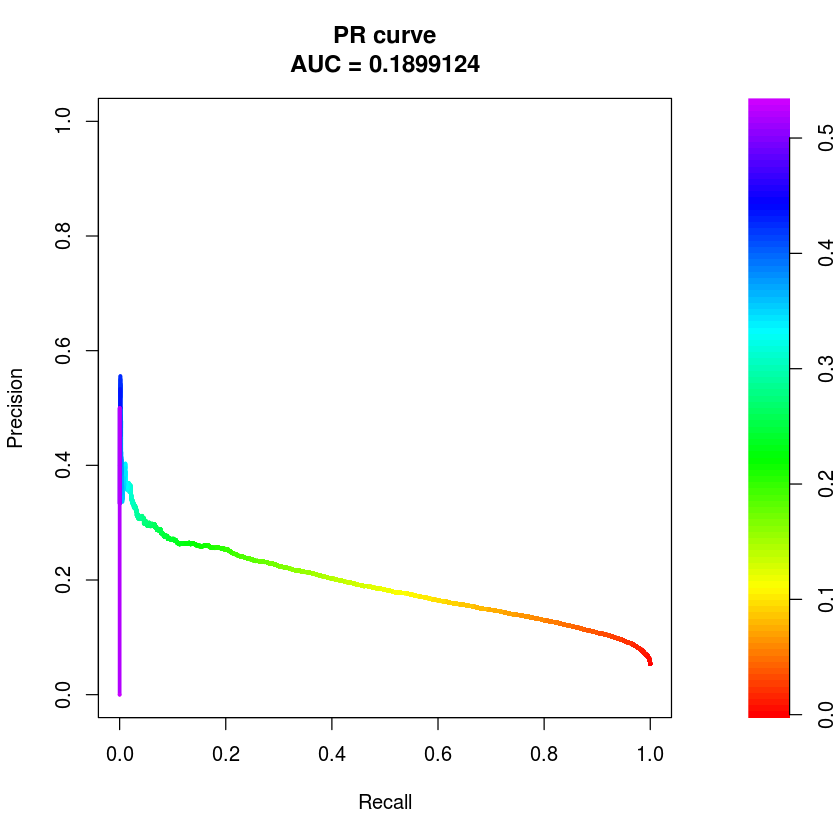

In [108]:
xgb.opt.prc <- pr.curve(scores.class0 = xgb.opt.pred.fg, scores.class1 = xgb.opt.pred.bg, curve = T)
plot(xgb.opt.prc)

**Calculate AUC**

In [109]:
xgb.opt.auc <- auc(roc(y_test$default, xgb.opt.pred))
xgb.opt.auc

Area under the curve: 0.8238

**Calculate F-score**

In [110]:
xgb.opt.f1 <- F1_Score(ifelse(xgb.opt.pred > 0.5, 1, 0), ifelse(y_test$default, 1, 0), positive = "0")
xgb.opt.f1

[1] 0.9726524

**Generate and Save Confusion Matrix**

In [104]:
xgb.opt.cm <- confusionMatrix(table(xgb.opt.pred > xgb.CSL.cv.opt2.threshold, y_test$default))
xgb.opt.cm

Confusion Matrix and Statistics

       
         FALSE   TRUE
  FALSE 117227   4731
  TRUE    8395   2332
                                          
               Accuracy : 0.9011          
                 95% CI : (0.8995, 0.9027)
    No Information Rate : 0.9468          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2116          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.9332          
            Specificity : 0.3302          
         Pos Pred Value : 0.9612          
         Neg Pred Value : 0.2174          
             Prevalence : 0.9468          
         Detection Rate : 0.8835          
   Detection Prevalence : 0.9192          
      Balanced Accuracy : 0.6317          
                                          
       'Positive' Class : FALSE           
                                 

**Calculate Feature Importance/Influence**

In [111]:
xgb.opt.imp <- xgb.importance(model = xgb.opt.mdl)
print(xgb.opt.imp)

                                   Feature         Gain        Cover
 1:                               int_rate 2.950606e-01 1.592069e-01
 2: quantity_indexes_for_real_gdp_by_state 2.296463e-01 1.886576e-01
 3:                      real_gdp_by_state 8.181268e-02 6.415944e-02
 4:                  initial_list_status_F 6.199753e-02 4.387092e-02
 5:           per_capita_real_gdp_by_state 4.254872e-02 6.096016e-02
 6:        taxes_on_production_and_imports 4.248315e-02 3.965745e-02
 7:              compensation_of_employees 4.237251e-02 5.596858e-02
 8:                              subsidies 3.730237e-02 7.783413e-02
 9:                gross_operating_surplus 3.498949e-02 6.354411e-02
10:                             annual_inc 3.493759e-02 4.744721e-02
11:                                  month 2.851295e-02 4.478193e-02
12:                  initial_list_status_W 1.050778e-02 1.054389e-02
13:                                    dti 8.378386e-03 2.619847e-02
14:                 purpose_SMALL_

**Plot Importance/Influence**

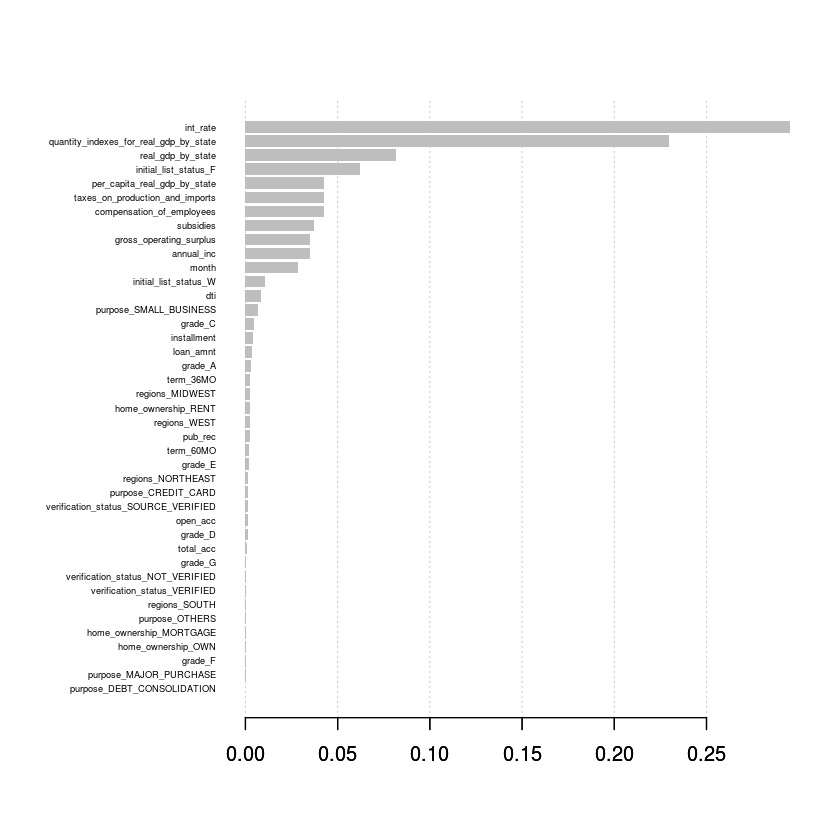

In [112]:
xgb.plot.importance(importance_matrix = xgb.opt.imp)

**Dump Tree**

In [113]:
xgb.dump(xgb.opt.mdl, with.stats = T, fname = "./models/xgb.opt.tree.costopt.txt")

Warning message:
“'with.stats' is deprecated.
Use 'with_stats' instead.
See help("Deprecated") and help("xgboost-deprecated").”

[1] TRUE

**Save Model**

In [114]:
xgb.save(xgb.opt.mdl, "./models/xgb.opt.costopt.mdl")

[1] TRUE

**Partial Graph (for 3 top vars)**

In [139]:
stime <- Sys.time()
xgb.opt.mdl.1p <- partial(xgb.opt.mdl, pred.var = "int_rate", train = x_train.1hot,
                         grid.resolution = 250, trim.outliers = FALSE, prob = TRUE, rug = TRUE, plot = TRUE)
print(Sys.time() - stime)

Time difference of 23.6353 mins


In [140]:
stime <- Sys.time()
xgb.opt.mdl.2p <- partial(xgb.opt.mdl, pred.var = "quantity_indexes_for_real_gdp_by_state", train = x_train.1hot,
                         grid.resolution = 250, trim.outliers = FALSE, prob = TRUE, rug = TRUE, plot = TRUE)
print(Sys.time() - stime)

Time difference of 24.29695 mins


In [141]:
stime <- Sys.time()
xgb.opt.mdl.3p <- partial(xgb.opt.mdl, pred.var = "annual_inc", train = x_train.1hot,
                         grid.resolution = 250, trim.outliers = FALSE, prob = TRUE, rug = TRUE, plot = TRUE)
print(Sys.time() - stime)

Time difference of 24.20846 mins


#### 4.2.4) Calculate Model Relative Losses

In [127]:
xgb.opt.cost.ratio <- ((xgb.opt.cm$table[2,1]*mreturns)+(xgb.opt.cm$table[1,2]*mloan_amnt)) / ((xgb.opt.cm$table[1,1]*mreturns))
xgb.opt.cost.ratio

[1] 0.2598753

### 4.3) Compare Models

#### 4.3.1) Plot Monotonic Constraint Differences for Top 3 features

In [142]:
xgb.mono.opt.mdl.1p.df <- as.data.frame(xgb.mono.opt.mdl.1p$panel.args)
xgb.mono.opt.mdl.1p.df$model <- "monotonic"
xgb.opt.mdl.1p.df <- as.data.frame(xgb.opt.mdl.1p$panel.args)
xgb.opt.mdl.1p.df$model <- "non-monotonic"
xgb.opt.mdl.1p.df <- rbind.data.frame(xgb.mono.opt.mdl.1p.df, xgb.opt.mdl.1p.df)
ggplot(xgb.opt.mdl.1p.df, aes(x=x, y=y)) + geom_line(aes(colour = model)) +
            xlab("int_rate") + ylab("yhat") + theme_minimal() + theme(legend.position=c(0.2, 0.8))

ERROR: Error in as.data.frame(xgb.mono.opt.mdl.1p$panel.args): object 'xgb.mono.opt.mdl.1p' not found


In [ ]:
xgb.mono.opt.mdl.2p.df <- as.data.frame(xgb.mono.opt.mdl.2p$panel.args)
xgb.mono.opt.mdl.2p.df$model <- "monotonic"
xgb.opt.mdl.2p.df <- as.data.frame(xgb.opt.mdl.2p$panel.args)
xgb.opt.mdl.2p.df$model <- "non-monotonic"
xgb.opt.mdl.2p.df <- rbind.data.frame(xgb.mono.opt.mdl.2p.df, xgb.opt.mdl.2p.df)
ggplot(xgb.opt.mdl.2p.df, aes(x=x, y=y)) + geom_line(aes(colour = model)) +
            xlab("quantity_indexes_for_real_gdp_by_state") + ylab("yhat") + theme_minimal() + theme(legend.position=c(0.6, 0.8))

In [ ]:
xgb.mono.opt.mdl.3p.df <- as.data.frame(xgb.mono.opt.mdl.3p$panel.args)
xgb.mono.opt.mdl.3p.df$model <- "monotonic"
xgb.opt.mdl.3p.df <- as.data.frame(xgb.opt.mdl.3p$panel.args)
xgb.opt.mdl.3p.df$model <- "non-monotonic"
xgb.opt.mdl.3p.df <- rbind.data.frame(xgb.mono.opt.mdl.3p.df, xgb.opt.mdl.3p.df)
ggplot(xgb.opt.mdl.3p.df, aes(x=x, y=y)) + geom_line(aes(colour = model)) +
            xlab("annual_inc") + ylab("yhat") + theme_minimal() + theme(legend.position=c(0.6, 0.8))